# Step 1: Clone the repository

Clone the git repository so train, validation and test data can be accessed in this notebook

In [2]:
! git clone https://github.com/ysharma12/VIntel.git
! ls

Cloning into 'VIntel'...
remote: Enumerating objects: 2776, done.
remote: Counting objects: 100% (2776/2776), done.
remote: Compressing objects: 100% (2756/2756), done.
remote: Total 2776 (delta 20), reused 2769 (delta 16), pack-reused 0
Receiving objects: 100% (2776/2776), 237.45 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (2980/2980), done.
sample_data  VIntel


# Step 2: Import modules

In [3]:
import os
import sys
import keras
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sklearn.metrics as sklm
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense,  Dropout, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Conv2D
from keras.models import Model,Sequential, load_model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras import backend as K
import tensorflow as tf
from scipy import misc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Step 3: Check for GPU run time

In [5]:
tf.test.gpu_device_name()
tf.test.is_gpu_available()

True

# Step 4: Create and compile the model

In [0]:
def get_pretrained_model():
  """Loads and modifies the VGG16 model for 10 classes"""
  model_vgg16 = VGG16(weights='imagenet', include_top=False)

  #freezing all layers
  for layer in model_vgg16.layers:
    layer.trainable = False

  #Setting input format
  keras_input = Input(shape=(224,224,3), name = 'image_input')

  #new vgg16 model 
  output_vgg16_conv = model_vgg16(keras_input)

  #New layers for 10 class classification
  new = Flatten(name='flatten')(output_vgg16_conv)
  new = Dense(4096, activation='relu', name='fc1')(new)
  new = Dense(4096, activation='relu', name='fc2')(new)
  new = Dense(10, activation='softmax', name='predictions')(new)

  pretrained_model = Model(inputs=keras_input, outputs=new)
  print("Compiling model ...")
#   pretrained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  pretrained_model.compile(loss='categorical_crossentropy',  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
  print("Finished model compiling ...")

  return pretrained_model  



# Step 5: Create image generators

In [0]:
def get_train_generator():
  """Creates a data generator with train images"""

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(
        'VIntel/train', # train directory
        target_size=(224, 224),  # all images get resized to 224x224
        batch_size=50,
        class_mode='categorical')

  return train_generator    


def get_validation_generator():
  """Creates a data generator with validation images"""

  validation_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

  validation_generator = validation_datagen.flow_from_directory(
        'VIntel/valid', # validation directory
        target_size=(224, 224),
        batch_size=59,
        shuffle=False,
        class_mode='categorical')    

  return validation_generator 


def get_test_generator():
  """Creates a data generator with test images"""
  test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
  
  test_generator = test_datagen.flow_from_directory(
        'VIntel/test',
        target_size=(224, 224),
        batch_size=59,
        shuffle=False,
        class_mode='categorical')    
  return test_generator

# Step 6: Helper functions for plotting

In [0]:
def plot_training_history(history):
  """Plots training history with loss and accuracy for each epoch"""
  acc = history.history['acc']
  loss = history.history['loss']
  epochs = range(len(acc))

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'go-', label='training acc')
  plt.title('Training accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'ro-', label='training loss')
  plt.title('Training loss')
  plt.legend()
  plt.show()
  
def get_model_plot():
  model = VGG16()
  plot_model(model, to_file='vgg_original.png')
  
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(18, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Step 7: Model training

In [11]:
print("getting train generator...")  
train_generator = get_train_generator()  
print("getting model...")  
model = get_pretrained_model()
print("Starting training...")
history = model.fit_generator(
        train_generator,
        steps_per_epoch=223, # batch_size 
        epochs=100)
print("Saving model...")          
# model.save("model_vintel_02_100_epochs")
model.save_weights("model_vintel_100_epochs.h5")


getting train generator...
Found 1784 images belonging to 10 classes.
getting model...
Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Compiling model ...
Finished model compiling ...
Starting training...
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
223/223 [==============================] - 296s 1s/step - loss: 1.8451 - acc: 0.3938
Epoch 2/100
223/223 [==============================] - 290s 1s/step - loss: 1.4051 - acc: 0.5788
Epoch 3/100
223/223 [==============================] - 292s 1s/step - loss: 1.2209 - acc: 0.6318
Epoch 4/100
223/223 [==============================] - 292s 1s/step - loss: 1.0998 - acc: 0.6645
Epoch 5/100
223/223 [==============================] - 292s 1s/step - loss: 1.0291 - acc: 0.6812
Epoch 6/100
223/223 [==============================] - 292s 1s/step - loss: 0.9666 - acc: 0.6995
Epoch 7/100
223/223 [==============================] - 288s 1s/step - loss: 

In [20]:
!ls

model.json  model_vintel_100_epochs.h5	sample_data  VIntel


# Step 8: Plot training loss and accuracy

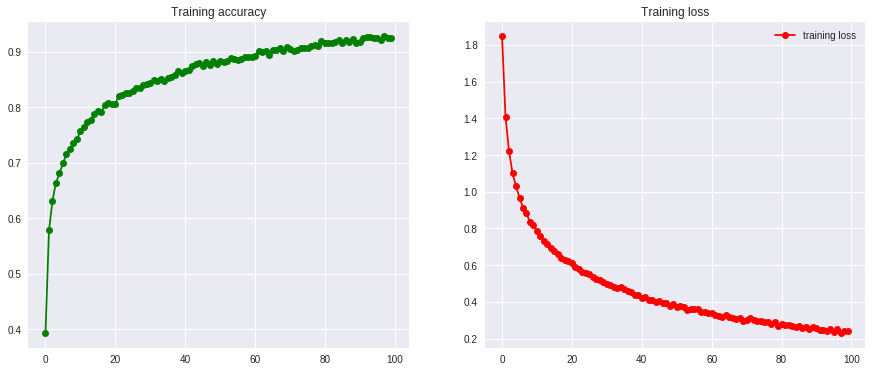

In [13]:
plot_training_history(history)


# Step 9: Model validation

In [14]:
print("getting validation generator...")
validation_generator = get_validation_generator()
print(validation_generator.class_indices)
batch_valid = 59
num_steps = 10
y = validation_generator.classes
# print("Model predictions")
valid_pred = model.predict_generator(validation_generator, steps=10, verbose=1)       
print(valid_pred.shape)
y_valid = np.argmax(valid_pred, axis=1)
# print('Confusion Matrix')
cm = confusion_matrix(y, y_valid)
# print(cm)

score = model.evaluate_generator(validation_generator, steps=10)
print(score)
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])


getting validation generator...
Found 590 images belonging to 10 classes.
{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}
10/10 [==============================] - 17s 2s/step
(590, 10)
[0.5727891892194747, 0.8338983118534088]
Validation Loss: 0.5727891892194747
Validation Accuracy: 0.8338983118534088


In [27]:
valid_classes = validation_generator.class_indices
print(valid_classes)
decode_valid_classes = {v: k for k, v in valid_classes.items()}
labels = valid_classes.keys()

{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}


Confusion matrix, without normalization
[[44  1  0  6  0  0  0  1  1  0]
 [ 1 75  1  1  0  1  0  1  0  2]
 [ 3  0 94  3  1  0  1  2  3  0]
 [ 1  2  3 54  0  1  0  1  0  0]
 [ 0  0  0  2 60  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  1  0 32  1  0  0]
 [ 6  3 10  6  3  2  2 69 12  3]
 [ 0  0  0  0  0  1  0  0 25  1]
 [ 0  1  3  2  0  0  1  0  6 31]]
Normalized confusion matrix
[[0.83018868 0.01886792 0.         0.11320755 0.         0.
  0.         0.01886792 0.01886792 0.        ]
 [0.01219512 0.91463415 0.01219512 0.01219512 0.         0.01219512
  0.         0.01219512 0.         0.02439024]
 [0.02803738 0.         0.87850467 0.02803738 0.00934579 0.
  0.00934579 0.01869159 0.02803738 0.        ]
 [0.01612903 0.03225806 0.0483871  0.87096774 0.         0.01612903
  0.         0.01612903 0.         0.        ]
 [0.         0.         0.         0.03174603 0.95238095 0.
  0.         0.         0.         0.01587302]
 [0.         0.         0.         0.         0.  

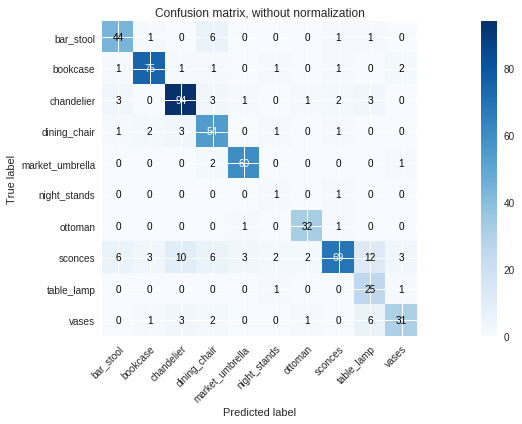

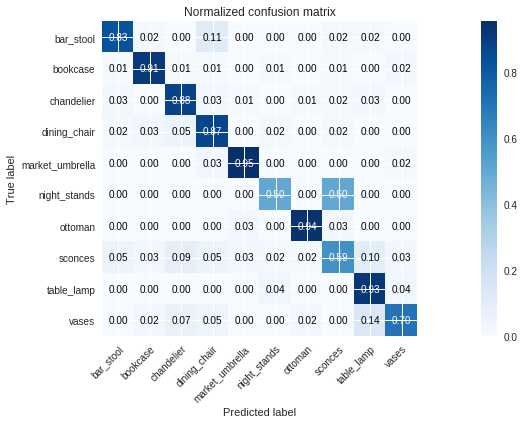

In [28]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_valid, y, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_valid, y, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [29]:
print(classification_report(validation_generator.classes, y_valid, target_names=labels))

                 precision    recall  f1-score   support

      bar_stool       0.83      0.80      0.81        55
       bookcase       0.91      0.91      0.91        82
     chandelier       0.88      0.85      0.86       111
   dining_chair       0.87      0.73      0.79        74
market_umbrella       0.95      0.92      0.94        65
   night_stands       0.50      0.17      0.25         6
        ottoman       0.94      0.89      0.91        36
        sconces       0.59      0.91      0.72        76
     table_lamp       0.93      0.53      0.68        47
          vases       0.70      0.82      0.76        38

      micro avg       0.82      0.82      0.82       590
      macro avg       0.81      0.75      0.76       590
   weighted avg       0.84      0.82      0.82       590



In [19]:
# model = load_model('model_vintel_100_epochs.h5')
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_vintel_100_epochs.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_vintel_100_epochs.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


# Step 10: Model testing

In [30]:
print("getting test generator...")
test_generator = get_test_generator()
print(test_generator.class_indices)
batch_test = 59
num_steps = 10
y = test_generator.classes
# print("Model predictions")
test_pred = model.predict_generator(test_generator, steps=10, verbose=1)       
print(test_pred.shape)
y_test = np.argmax(test_pred, axis=1)
# print('Confusion Matrix')
cm = confusion_matrix(y, y_test)
# print(cm)

score = model.evaluate_generator(test_generator, steps=10)
print(score)
print("test Loss:", score[0])
print("test Accuracy:", score[1])

getting test generator...
Found 590 images belonging to 10 classes.
{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}
10/10 [==============================] - 16s 2s/step
(590, 10)
[0.6202584594488144, 0.8084745764732361]
test Loss: 0.6202584594488144
test Accuracy: 0.8084745764732361


In [37]:
print(classification_report(test_generator.classes, y_test, target_names=labels))

                 precision    recall  f1-score   support

      bar_stool       0.75      0.75      0.75        55
       bookcase       0.87      0.87      0.87        82
     chandelier       0.77      0.80      0.79       111
   dining_chair       0.80      0.85      0.82        74
market_umbrella       0.90      0.95      0.93        65
   night_stands       1.00      0.50      0.67         6
        ottoman       0.91      0.86      0.89        36
        sconces       0.67      0.75      0.71        76
     table_lamp       0.93      0.57      0.71        47
          vases       0.69      0.71      0.70        38

      micro avg       0.80      0.80      0.80       590
      macro avg       0.83      0.76      0.78       590
   weighted avg       0.81      0.80      0.80       590



Confusion matrix, without normalization
[[41  1  3  6  1  0  0  2  1  0]
 [ 3 71  2  2  0  1  0  2  1  0]
 [ 2  1 89  0  0  1  0 12  6  4]
 [ 6  2  3 63  0  0  0  2  1  2]
 [ 0  3  2  0 62  0  1  0  1  0]
 [ 0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0 31  0  0  2]
 [ 2  2 10  1  1  1  1 57  8  2]
 [ 0  0  0  0  1  0  0  0 27  1]
 [ 1  2  2  1  0  0  3  1  2 27]]
Normalized confusion matrix
[[0.74545455 0.01818182 0.05454545 0.10909091 0.01818182 0.
  0.         0.03636364 0.01818182 0.        ]
 [0.03658537 0.86585366 0.02439024 0.02439024 0.         0.01219512
  0.         0.02439024 0.01219512 0.        ]
 [0.0173913  0.00869565 0.77391304 0.         0.         0.00869565
  0.         0.10434783 0.05217391 0.03478261]
 [0.07594937 0.02531646 0.03797468 0.79746835 0.         0.
  0.         0.02531646 0.01265823 0.02531646]
 [0.         0.04347826 0.02898551 0.         0.89855072 0.
  0.01449275 0.         0.01449275 0.        ]
 [0.         0.         0.         0.         0.  

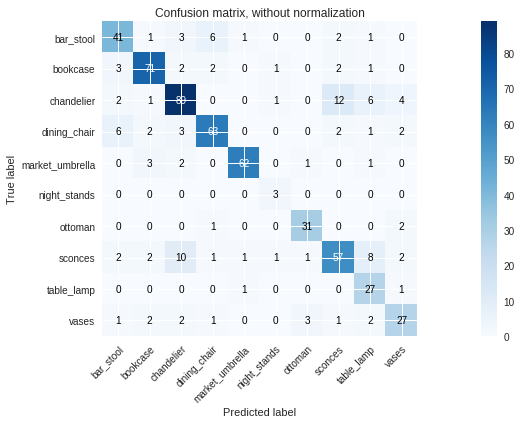

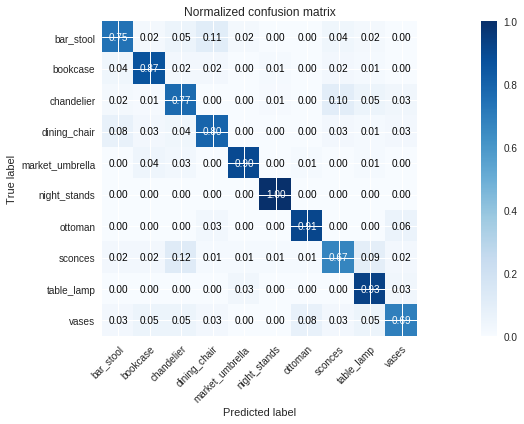

In [31]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Step 11: Test prediction examples

In [32]:
test_classes = test_generator.class_indices
print(test_classes)
decode_test_classes = {v: k for k, v in test_classes.items()}

{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}


In [0]:
num_samples = 20

590
[242, 381, 412, 116, 585, 265, 470, 456, 294, 473, 574, 107, 439, 494, 103, 80, 547, 438, 351, 426]


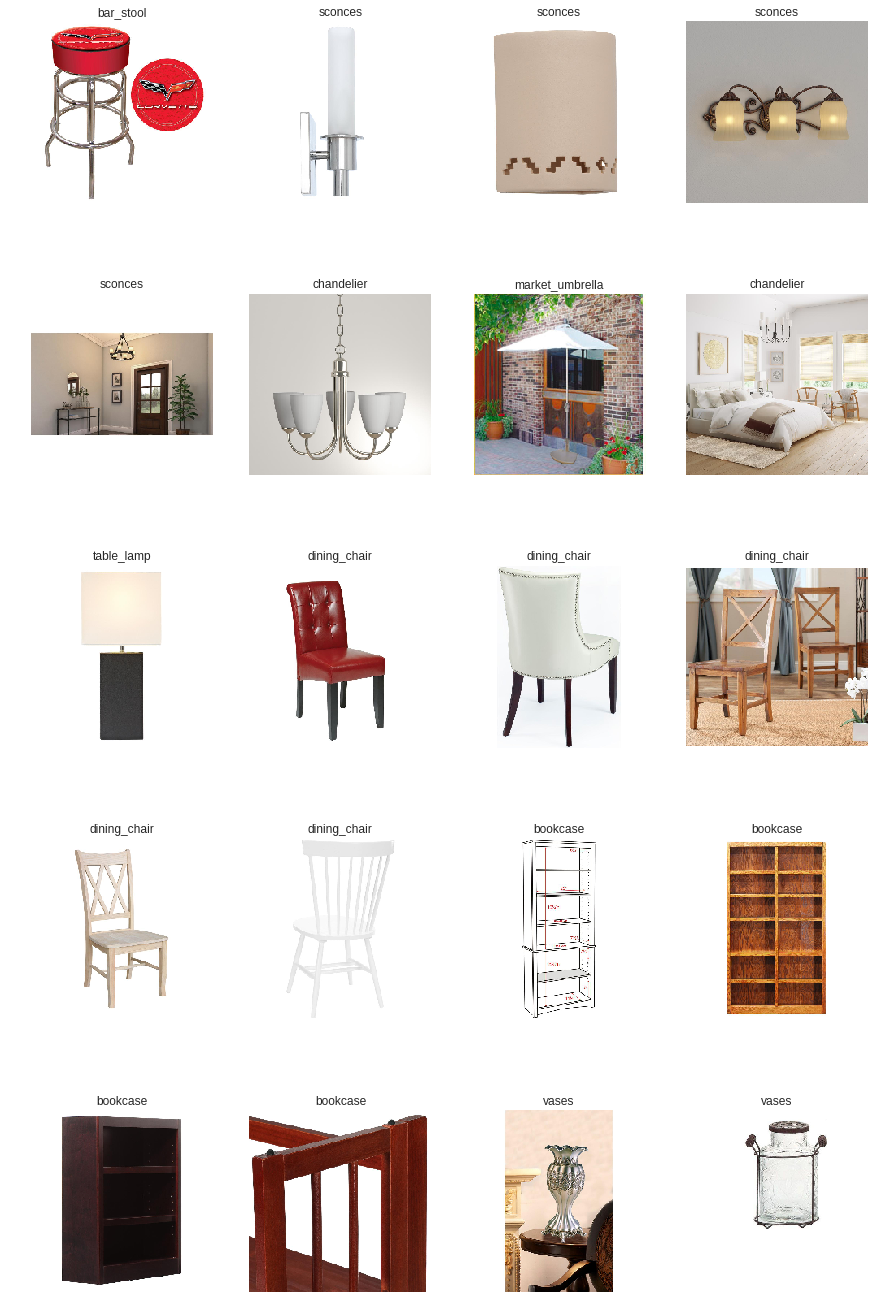

In [34]:
test_dir = 'VIntel/test'

filenames_full = []
for dirpath, dirnames, filenames in os.walk(test_dir):
    for filename in filenames:
      if filename != '.DS_Store':
        filenames_full.append(os.path.join(dirpath, filename))

print(len(filenames_full))
rand_indices = random.sample(range(1, len(filenames_full)), num_samples)
print(rand_indices)
rows = (len(filenames_full) - 1) // 4 + 1
plt.figure(figsize=(15, 5 * rows))
cnt = 0
for index, filename_full in enumerate(filenames_full):
  if index in rand_indices:
    plt.subplot(rows, 4, cnt + 1)
    test_image = keras.preprocessing.image.load_img(filename_full, target_size=(224, 224))
    test_input = keras.preprocessing.image.img_to_array(test_image) * (1. / 255)
    test_input = np.expand_dims(test_input, axis=0)
    plt.imshow(test_image)
    plt.axis('off')
    prediction = model.predict(test_input)
    type_name = decode_test_classes[np.argmax(prediction[0])]
    plt.title(type_name)
    cnt = cnt + 1
    if cnt > num_samples:
      break


In [0]:
# download modelfile
# from google.colab import files
# files.download('model.json')
# files.download('model_vintel_100_epochs.h5')